# **DEMO**
For this demo to work, we need to test data available in the same folder.
We will first define the network structure since we will only load the weight parameters.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms 
import torch.nn as nn  
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import copy
import cv2
from PIL import Image
import os

In [2]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [3]:
class PartialConv(nn.Module):
    """
    Implements a partial convolution layer, which only considers valid pixels in the convolution operation.
    This is particularly useful for tasks like inpainting where the input image may have missing values.
    """
    def __init__(self, in_filters, out_filters, kernel_size, strides=1, padding=0, dilation=1, groups=1, bias=True):
        super(PartialConv, self).__init__()
        
        # Calculate padding based on the kernel size to ensure the output size is the same as the input size
        padding = (kernel_size[0] // 2, kernel_size[1] // 2)
        self.input_conv = nn.Conv2d(in_filters, out_filters, kernel_size, strides, padding, bias=bias)
        
        # Convolution for mask with weights initialized to 1 and set to not require gradients
        self.mask_conv = nn.Conv2d(in_filters, out_filters, kernel_size, strides, padding, bias=False)
        
        # Constant value for normalizing the mask
        self.window_size = kernel_size[0] * kernel_size[1]
        
        # Initialize mask convolution weights to 1
        nn.init.constant_(self.mask_conv.weight, 1.0)
        
        # Freeze the mask convolution weights
        for param in self.mask_conv.parameters():
            param.requires_grad = False

    def forward(self, input, mask):
        """
        Forward pass of the partial convolution layer.
        
        Parameters:
        - input: The input image.
        - mask: A binary mask indicating which pixels are valid (1) and which are missing (0).
        
        Returns:
        - output: The convolved image, adjusted for valid pixel coverage.
        - output_mask: The updated mask after convolution.
        """
        output = self.input_conv(input * mask)
        
        # Add bias if present, reshaped to match output dimensions
        if self.input_conv.bias is not None:
            output_bias = self.input_conv.bias.view(1, -1, 1, 1).expand_as(output)
        else:
            output_bias = torch.zeros_like(output)

        with torch.no_grad():
            output_mask = self.mask_conv(mask)
            
        # Calculate mask ratio to adjust the convolution output based on the coverage of valid pixels
        mask_ratio = self.window_size / (output_mask + 1e-8)

        output_mask = torch.clamp(output_mask, 0, 1)
  
        mask_ratio = mask_ratio * output_mask
    
        # Adjust output based on valid pixel coverage and add bias
        output = output * mask_ratio
        output = output + output_bias

        return output, output_mask

In [4]:
class EncoderLayer(nn.Module):
    """
    Encoder layer used in the inpainting model, consisting of two partial 
    convolution layers followed by batch normalization and ReLU activation.
    """
    def __init__(self, in_filters, out_filters):
        super(EncoderLayer, self).__init__()
        self.p_conv_1 = PartialConv(in_filters, out_filters, (3, 3), strides=1)
        self.bn_1 = nn.BatchNorm2d(out_filters)
        self.act_1 = nn.ReLU()
        self.p_conv_2 = PartialConv(out_filters, out_filters, (3, 3), strides=2)
        self.bn_2 = nn.BatchNorm2d(out_filters)
        self.act_2 = nn.ReLU()

    def forward(self, inputs, masks):
        """
        Forward pass of the encoder layer, applying two sequential partial convolutions to both inputs and masks.
        
        Parameters:
        - inputs: The input image.
        - masks: The corresponding binary masks.
        
        Returns:
        - A tuple of convolved images and updated masks after each convolution layer.
        """
        conv_out_1, mask_out_1 = self.p_conv_1(inputs, masks)
        conv_out_1 = self.act_1(self.bn_1(conv_out_1))

        conv_out_2, mask_out_2 = self.p_conv_2(conv_out_1, mask_out_1)
        conv_out_2 = self.act_2(self.bn_2(conv_out_2))

        return conv_out_1, mask_out_1, conv_out_2, mask_out_2

In [5]:
class DecoderLayer(nn.Module):
    """
    Decoder layer for the inpainting model, which upsamples the input features 
    and combines them with features from the skip connections, followed 
    by partial convolutions to refine the features for accurate image reconstruction.
    """
    def __init__(self, in_filters_1, in_filters_2):
        super(DecoderLayer, self).__init__()
        
        # Upsample the image and mask to the higher resolution
        self.up_image = nn.Upsample(scale_factor=(2, 2))
        self.up_mask = nn.Upsample(scale_factor=(2, 2))
        
        self.p_conv_1 = PartialConv(in_filters_1 * 2, in_filters_1, (3, 3))
        self.bn_1 = nn.BatchNorm2d(in_filters_1)
        self.act_1 = nn.LeakyReLU(negative_slope=0.2)

        self.p_conv_2 = PartialConv(in_filters_1, in_filters_2, (3, 3))
        self.bn_2 = nn.BatchNorm2d(in_filters_2)
        self.act_2 = nn.LeakyReLU(negative_slope=0.2)

    def forward(self, in_image, in_mask, share_image, share_mask):
        """
        Forward pass of the decoder layer.

        Parameters:
        - in_image: The image features from the previous decoder layer.
        - in_mask: The mask from the previous decoder layer.
        - share_image: The corresponding image features from the encoder layer (skip connection).
        - share_mask: The corresponding mask from the encoder layer (skip connection).

        Returns:
        - A tuple of the convolved images and updated masks after each partial convolution layer.
        """
        up_out = self.up_image(in_image)
        mask_out = self.up_mask(in_mask)
        
        # Concatenate the upsampled features with the features from the skip connection
        concat_image = torch.cat([share_image, up_out], axis=1)
        concat_mask = torch.cat([share_mask, mask_out], axis=1)

        conv_out_1, mask_out_1 = self.p_conv_1(concat_image, concat_mask)
        conv_out_1 = self.act_1(self.bn_1(conv_out_1))
    
        conv_out_2, mask_out_2 = self.p_conv_2(conv_out_1, mask_out_1)
        conv_out_2 = self.act_2(self.bn_2(conv_out_2))

        return conv_out_1, mask_out_1, conv_out_2, mask_out_2

In [6]:
class InpaintingModel(nn.Module):
    def __init__(self, input_dims=(64, 64), num_channels=3):
        super(InpaintingModel, self).__init__()

        self.encoder_1 = EncoderLayer(num_channels, 32)
        self.encoder_2 = EncoderLayer(32, 64)
        self.encoder_3 = EncoderLayer(64, 128)
        self.encoder_4 = EncoderLayer(128, 256)

        self.decoder_1 = DecoderLayer(256, 128)
        self.decoder_2 = DecoderLayer(128, 64)
        self.decoder_3 = DecoderLayer(64, 32)
        self.decoder_4 = DecoderLayer(32, 3)

        self.output_layer = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=5, padding=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True), 

            nn.Conv2d(256, 3, kernel_size=5, padding=2),
            nn.Sigmoid()
        )

    def forward(self, inputs, masks):
        conv_out_1, mask_out_1, conv_out_2, mask_out_2 = self.encoder_1(inputs, masks)
        conv_out_3, mask_out_3, conv_out_4, mask_out_4 = self.encoder_2(conv_out_2, mask_out_2)
        conv_out_5, mask_out_5, conv_out_6, mask_out_6 = self.encoder_3(conv_out_4, mask_out_4)
        conv_out_7, mask_out_7, conv_out_8, mask_out_8 = self.encoder_4(conv_out_6, mask_out_6)

        _, _, _, _ = self.decoder_1(conv_out_8, mask_out_8, conv_out_7, mask_out_7)
        _, _, _, _ = self.decoder_2(conv_out_6, mask_out_6, conv_out_5, mask_out_5)
        _, _, _, _ = self.decoder_3(conv_out_4, mask_out_4, conv_out_3, mask_out_3)
        _, _, conv_out_16, _ = self.decoder_4(conv_out_2, mask_out_2, conv_out_1, mask_out_1)

        outputs = self.output_layer(conv_out_16)
        return outputs

In [7]:
model = InpaintingModel()
model.load_state_dict(torch.load('./model_final.pt'))
model.eval()
model = model.to(device)

In [8]:
class Dataset(torchvision.datasets.Flowers102):
  def __init__(self, path, image_dims = (64, 64), n_channels = 3, split='train'):
    super().__init__(path, split, download = True)
    self.n_classes = 102
    self.image_dims = image_dims
    self.n_channels = n_channels
    self.resize = transforms.Resize(image_dims)
    self.to_tensor = transforms.ToTensor()

  def __getitem__(self, index):
    image, label = super().__getitem__(index)

    Y_output = self.resize(image)
    X_input, X_mask = self.Create_Mask(Y_output)
    return self.to_tensor(X_input), self.to_tensor(X_mask), self.to_tensor(Y_output)

  def Create_Mask(self, image):
    mask = np.full((self.image_dims[0], self.image_dims[1], self.n_channels), 255, dtype = np.uint8)

    for _ in range(np.random.randint(3, 10)):
      x1, x2 = np.random.randint(1, self.image_dims[0]), np.random.randint(1, self.image_dims[0])
      y1, y2 = np.random.randint(1, self.image_dims[1]), np.random.randint(1, self.image_dims[1])
      thickness = np.random.randint(2, 4)

      cv2.line(mask, (x1, y1), (x2, y2), (1, 1, 1), thickness)

    image = np.asarray(image)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image, mask
  
image_dims = (64, 64)
batch_size = 64
Testset = Dataset('./data', image_dims, split='test')
Testloader = torch.utils.data.DataLoader(Testset, batch_size = batch_size, shuffle = False)
Test_dataiter = iter(Testloader)

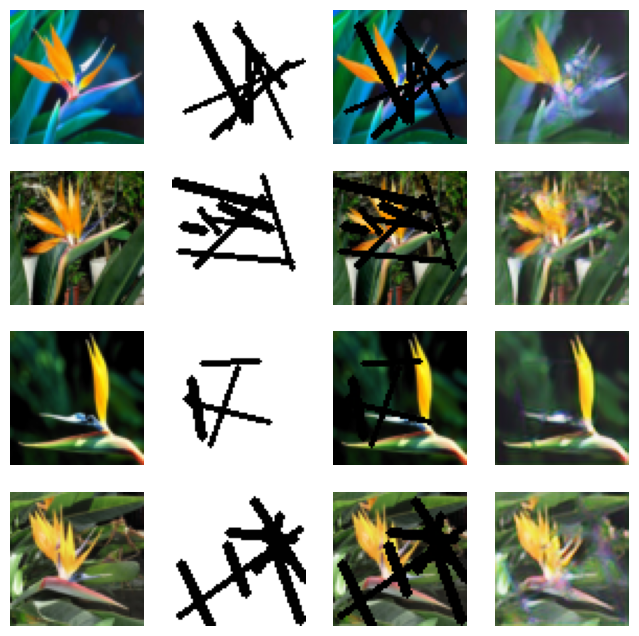

In [13]:
sample_inputs, sample_masks, sample_truths = next(Test_dataiter)
sample_inputs, sample_masks = sample_inputs.cuda(), sample_masks.cuda()

model.eval()
with torch.no_grad():
    sample_preds = model(sample_inputs, sample_masks)

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

for i in range(4):
    axs[i][0].imshow(np.transpose(sample_truths[i], (1, 2, 0)))
    axs[i][0].axis('off')
    axs[i][1].imshow(np.transpose(sample_masks[i].cpu(), (1, 2, 0)))
    axs[i][1].axis('off')
    axs[i][2].imshow(np.transpose(sample_inputs[i].cpu(),(1, 2, 0)))
    axs[i][2].axis('off')
    axs[i][3].imshow(np.transpose(sample_preds[i].cpu(), (1, 2, 0)))
    axs[i][3].axis('off')
plt.show()